# Prueba Técnica

En este Jupyter notebook se realizaran las siguientes tareas:
1. Análisis exploratorio y preparación de datos 
2. Desarrollo del modelo de recomendación. 
3. Armado de la función de recomendación basado en el modelo
   
Una vez que el modelo este listo se desarrollara una API que permita consultar recomendaciones a los usuarios usando la función.

In [1]:
# Importamos librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import joblib

## Exploración y preparación de datos

In [2]:
# Leo los datos de ratings como un pandas DataFrame
u_data_path = "/home/eduardo/pyfiles/ml-100k/u.data"
column_names_data = ['userId', 'movieId', 'rating', 'timestamp']
ratings  = pd.read_csv(u_data_path, sep='\t', names=column_names_data)

ratings.head(5)

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# Leo los datos de los items como un pandas DataFrame
u_items_path = "/home/eduardo/pyfiles/ml-100k/u.item"
column_names_item = ['movieId' , 'title' , 'release_date' , 'video_release_date' ,
              'IMDb_URL' , 'unknown_genre' , 'Action' , 'Adventure' , 'Animation' ,
              'Childrens', 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci_Fi' ,
              'Thriller' , 'War' , 'Western']
u_item = pd.read_csv(u_items_path, sep='|', names=column_names_item, encoding='latin-1') 
u_item= u_item.drop(columns=['video_release_date', 'IMDb_URL', 'release_date'])

u_item.head(5)

,movieId,title,unknown_genre,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# Realizo un merge de los dos DataFrames
df = pd.merge(ratings, u_item, on='movieId', how='left')
df.head(5)

,userId,movieId,rating,timestamp,title,unknown_genre,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,L.A. Confidential (1997),0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,Heavyweights (1994),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,Legends of the Fall (1994),0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,Jackie Brown (1997),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Comenzamos la exploración de los datos con describe(). Solo usaremos columnas que nos puedan aportar valor de análisis por lo que eliminamos userId movieId y timestamp	
df.drop(columns=['userId','movieId', 'timestamp']).describe()

,rating,unknown_genre,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
count,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000
mean,3.529860,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,0.007580,0.398950,0.013520,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540
std,1.125674,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,0.086733,0.489685,0.115487,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894
min,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,3.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,4.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,4.000000,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,5.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


El análisis de los datos de este resumen estadístico para los ratings y géneros de películas revela algunos puntos interesantes:

**Distribución de los ratings**: 

La media de los ratings es 3.53 con una desviación estándar de 1.13, lo que indica que la mayoría de los ratings están centrados alrededor de 3 o 4 estrellas. Los ratings están en un rango de 1 a 5, y el 50% de las películas tienen un rating de 4 o menos (mediana), lo que sugiere una tendencia a dar puntuaciones positivas.

**Presencia de géneros:**

Algunos géneros como Drama (39.9%) y Acción (25.6%) son muy comunes, con una media alta indicando que estos géneros están presentes en una cantidad significativa de películas.
Géneros como Western (9.4%) y Film-Noir (1.4%) son menos comunes, como se muestra por sus medias bajas.
La columna de unknown_genre tiene un valor mínimo (solo 0.01%), lo que sugiere que casi todas las películas tienen un género claramente definido.

**Varianza en los géneros:** 

La alta desviación estándar en géneros como Acción, Drama y Comedia sugiere que hay una gran variación en su presencia entre las películas. Esto puede indicar que estos géneros se encuentran tanto en películas populares como en menos populares.

**Géneros poco frecuentes:** 

Géneros como Documental, Musical, Western y Film-Noir tienen bajas medias y grandes diferencias entre el percentil 25% y 75%, indicando que solo una pequeña fracción de películas pertenece a estos géneros.

In [6]:
# Ver el número de filas y columnas
shape = df.shape
print("Número de filas y columnas:", shape)

# Ver tipos de datos
data_types = df.dtypes
print("Tipos de datos:", data_types)


Número de filas y columnas: (100000, 24)
Tipos de datos: userId            int64
movieId           int64
rating            int64
timestamp         int64
title            object
unknown_genre     int64
Action            int64
Adventure         int64
Animation         int64
Childrens         int64
Comedy            int64
Crime             int64
Documentary       int64
Drama             int64
Fantasy           int64
Film_Noir         int64
Horror            int64
Musical           int64
Mystery           int64
Romance           int64
Sci_Fi            int64
Thriller          int64
War               int64
Western           int64
dtype: object


In [7]:
# Verificar valores nulos
null_values = df.isnull().sum()
print("Cantidad de valores nulos:", null_values) 

Cantidad de valores nulos: userId           0
movieId          0
rating           0
timestamp        0
title            0
unknown_genre    0
Action           0
Adventure        0
Animation        0
Childrens        0
Comedy           0
Crime            0
Documentary      0
Drama            0
Fantasy          0
Film_Noir        0
Horror           0
Musical          0
Mystery          0
Romance          0
Sci_Fi           0
Thriller         0
War              0
Western          0
dtype: int64


No se encuentran valores nulos en ninguna columna

In [8]:
# Verificar filas duplicadas
sin_duplicados = df.drop_duplicates()
sin_duplicados

,userId,movieId,rating,timestamp,title,unknown_genre,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,L.A. Confidential (1997),0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,Heavyweights (1994),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,Legends of the Fall (1994),0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,Jackie Brown (1997),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,879795543,Back to the Future (1985),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99997,276,1090,1,874795795,Sliver (1993),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99998,13,225,2,882399156,101 Dalmatians (1996),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Tampoco hay filas duplicadas 

In [9]:
# Contamos la cantidad de películas por género para saber si hay categorías que no tienen películas
generos = ['unknown_genre','Action' , 'Adventure' , 'Animation' ,
    'Childrens', 'Comedy' , 'Crime' , 'Documentary' , 
    'Drama' , 'Fantasy' ,'Film_Noir' , 'Horror' , 
    'Musical' , 'Mystery' , 'Romance' , 'Sci_Fi' ,
    'Thriller' , 'War' , 'Western']

In [10]:
# Creamos una función para contar cuantas películas hay en cada genero
def contar_peliculas_por_generos(df, generos):
    cuenta_final = dict()
    for genero in generos:
        try:
            contar_genero = df[genero].value_counts()[1]
        except:
            contar_genero = 0
        cuenta_final[genero] = contar_genero
    
    return cuenta_final     

In [11]:
# Llamamos la función contar_peliculas_por_generos
peliculas_por_generos = contar_peliculas_por_generos(df, generos)
peliculas_por_generos

{'unknown_genre': 10,
 'Action': 25589,
 'Adventure': 13753,
 'Animation': 3605,
 'Childrens': 7182,
 'Comedy': 29832,
 'Crime': 8055,
 'Documentary': 758,
 'Drama': 39895,
 'Fantasy': 1352,
 'Film_Noir': 1733,
 'Horror': 5317,
 'Musical': 4954,
 'Mystery': 5245,
 'Romance': 19461,
 'Sci_Fi': 12730,
 'Thriller': 21872,
 'War': 9398,
 'Western': 1854}

**Géneros más frecuentes:**

Drama es el género más representado con 39895 películas, seguido de Comedy (29832) y Action (25589). Esto muestra que estos géneros son los más comunes en el conjunto de datos.

**Géneros menos comunes:**

Documentary (758), Film-Noir (1733) y Western (1854) son los géneros menos representados. Estos géneros son relativamente nichos y están presentes en una fracción pequeña de las películas.

**Películas de múltiples géneros:**

La suma total de las películas en los géneros supera las 100,000 (el total de películas), lo que sugiere que muchas películas pertenecen a múltiples géneros, algo común en los datos de películas.

**Género desconocido:**

Hay solo 10 películas clasificadas con unknown_genre, lo que indica que casi todas las películas tienen un género claramente definido.

In [12]:
# luego del anterior análisis eliminaremos timestamp  porque no es útil
data = df.drop(['timestamp'], axis=1)
data

,userId,movieId,rating,title,unknown_genre,Action,Adventure,Animation,Childrens,Comedy,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,196,242,3,Kolya (1996),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,L.A. Confidential (1997),0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,Heavyweights (1994),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,Jackie Brown (1997),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,"First Wives Club, The (1996)",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,Back to the Future (1985),0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
99997,276,1090,1,Sliver (1993),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99998,13,225,2,101 Dalmatians (1996),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Observemos la distribución de los ratings 
data['rating'].value_counts()

rating
4    34174
3    27145
5    21201
2    11370
1     6110
Name: count, dtype: int64

Comenzamos con el análisis gráfico

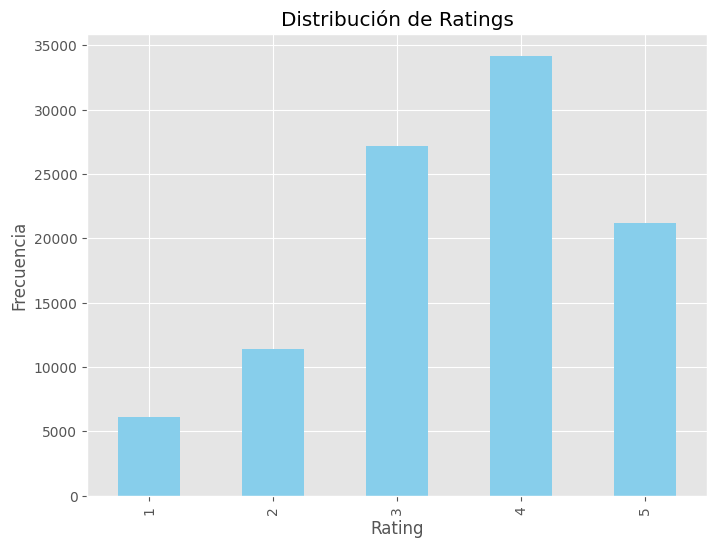

In [14]:
# Configuración general para los gráficos
plt.style.use('ggplot')

# Distribución de Ratings para visualizar la distribución de los datos
plt.figure(figsize=(8, 6))
data['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

La distribución parece estar sesgada hacia los valores más altos (especialmente hacia 3 y 4).

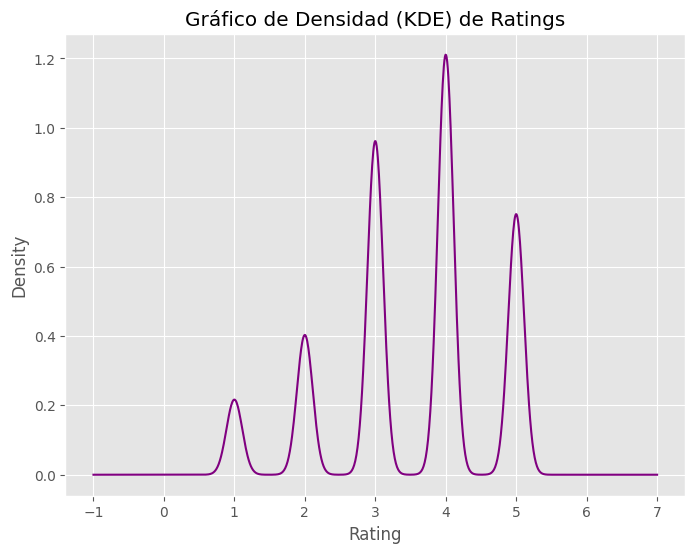

In [15]:
# Gráfico de densidad de los Ratings (KDE)
plt.figure(figsize=(8, 6))
data['rating'].plot(kind='kde', color='purple')
plt.title('Gráfico de Densidad (KDE) de Ratings')
plt.xlabel('Rating')
plt.show()


Ofrece una visualización suavizada de la distribución. La forma refuerza la observación de que los ratings están sesgados y no siguen una distribución normal estándar.

In [16]:
#Veamos cuales son los usuarios que mas ratings han realizado
data['userId'].value_counts()

userId
405    737
655    685
13     636
450    540
276    518
      ... 
441     20
36      20
812     20
895     20
93      20
Name: count, Length: 943, dtype: int64

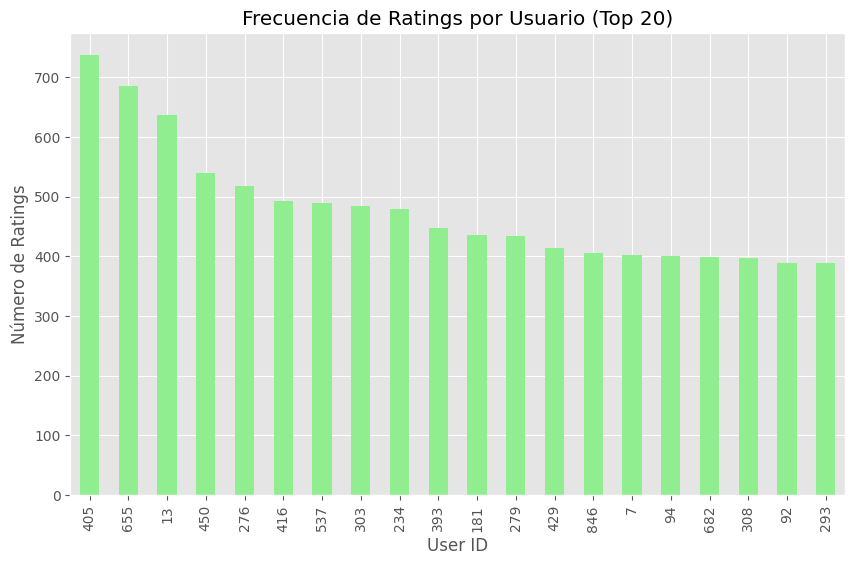

In [17]:
# Distribución de User IDs (primeros 20 usuarios)
plt.figure(figsize=(10, 6))
data["userId"].value_counts().head(20).plot(kind='bar', color='lightgreen')
plt.title('Frecuencia de Ratings por Usuario (Top 20)')
plt.xlabel('User ID')
plt.ylabel('Número de Ratings')
plt.show()


Presenta los 20 usuarios más activos, mostrando cuántas veces cada uno ha calificado ítems. Se observa una alta variabilidad en la actividad de los usuarios.

In [18]:
# Veamos cuales son las películas que mas ratings poseen 
data['movieId'].value_counts()

movieId
50      583
258     509
100     508
181     507
294     485
       ... 
852       1
1505      1
1653      1
1452      1
1641      1
Name: count, Length: 1682, dtype: int64

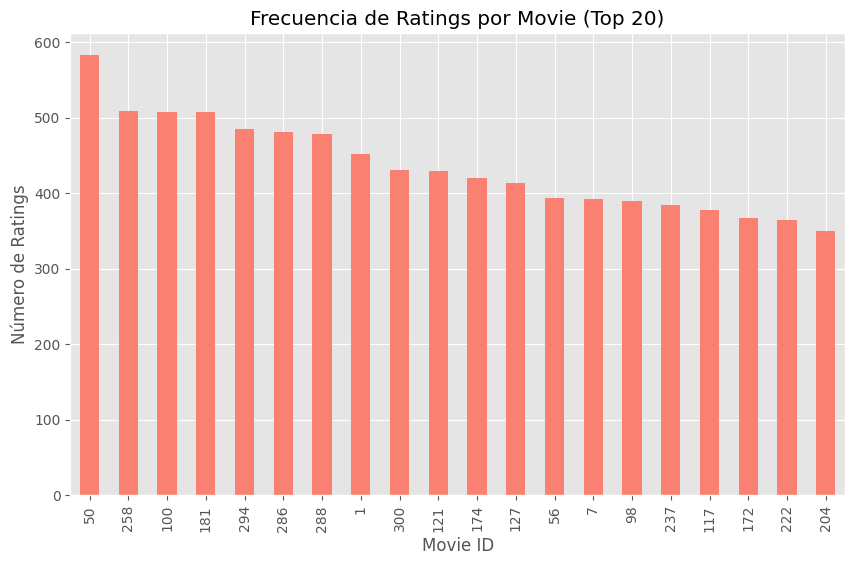

In [19]:
# Distribución de movieId (primeros 20 items)
plt.figure(figsize=(10, 6))
data["movieId"].value_counts().head(20).plot(kind='bar', color='salmon')
plt.title('Frecuencia de Ratings por Movie (Top 20)')
plt.xlabel('Movie ID')
plt.ylabel('Número de Ratings')
plt.show()

Muestra los 20 ítems que han recibido más calificaciones, indicando cuáles son los más populares entre los usuarios.

---

## Desarrollo del Sistema de Recomendación

Usaré la librería surprice para el modelado del sistema de recomendación.

In [20]:
# Comenzamos definiendo el reader de surprice con la escala de los ratings
reader = Reader(rating_scale=(1, 5))

# Luego cargo el DataFrame con el método load_from_df de la clase Dataset para poder usar surprice
dataset = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

# Realizo un split de los datos en caso que lo necesite posteriormente
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=123)

Procedo a definir los algoritmos mas usados para recomendación y sus respectivos parameters_grids en un diccionario.
Con el diccionario usare Grid Search para hacer fine-tuning y comparar los modelos, con el propósito de seleccionar el modelo con mayor performance y conocer los mejores parámetros.

In [21]:

algorithms = {
    'SVD': (SVD, {
        'n_factors': [20, 50, 100],
        'n_epochs': [20, 30],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.02, 0.1]
    }),
    'KNNBasic': (KNNBasic, {
        'k': [20, 30, 40],
        'min_k': [1, 5, 10],
        'sim_options': {
            'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
            'user_based': [True, False]
        }
    }),
    'KNNWithMeans': (KNNWithMeans, {
        'k': [20, 30, 40],
        'min_k': [1, 5, 10],
        'sim_options': {
            'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
            'user_based': [True, False]
        }
    }),
    'KNNBaseline': (KNNBaseline, {
        'k': [20, 30, 40],
        'min_k': [1, 5, 10],
        'bsl_options': {
            'method': ['als', 'sgd'],
            'n_epochs': [5, 10],
            'reg_u': [12, 15],
            'reg_i': [5, 10]
        },
        'sim_options': {
            'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
            'user_based': [True, False]
        }
    }),
    'NMF': (NMF, {
        'n_factors': [10, 20, 50],
        'n_epochs': [50, 100],
        'biased': [True, False]
    }),
    'SVDpp': (SVDpp, {
        'n_factors': [20, 50, 100],
        'n_epochs': [10, 20, 30],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.02, 0.1]
    }),
    'CoClustering': (CoClustering, {
        'n_cltr_u': [3, 5, 10],
        'n_cltr_i': [3, 5, 10],
        'n_epochs': [20, 40, 60]
    })
}

¡**ATENCIÓN:** La siguiente celda demoró 127 minutos en completarse!

In [ ]:
best_models = {}
for name, (algo_class, param_grid) in algorithms.items():
    print(f"Running GridSearchCV for {name}...")
    gs = GridSearchCV(algo_class, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
    gs.fit(data)
    
    best_models[name] = {
        'best_score': gs.best_score['rmse'],
        'best_params': gs.best_params['rmse'],
        'algo': gs.best_estimator['rmse']
    }

    print(f"Best RMSE score for {name}: {gs.best_score['rmse']}")
    print(f"Best parameters for {name}: {gs.best_params['rmse']}")

Running GridSearchCV for SVD...
Best RMSE score for SVD: 0.9271562008943967
Best parameters for SVD: {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}
Running GridSearchCV for KNNBasic...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix

In [ ]:
best_models

{'SVD': {'best_score': 0.9271562008943967,
  'best_params': {'n_factors': 100,
   'n_epochs': 30,
   'lr_all': 0.005,
   'reg_all': 0.1},
  'algo': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7fb654e5e810>},
 'KNNBasic': {'best_score': 0.9749510798298825,
  'best_params': {'k': 40,
   'min_k': 1,
   'sim_options': {'name': 'msd', 'user_based': False}},
  'algo': <surprise.prediction_algorithms.knns.KNNBasic at 0x7fb65d543aa0>},
 'KNNWithMeans': {'best_score': 0.9217728442042853,
  'best_params': {'k': 40,
   'min_k': 1,
   'sim_options': {'name': 'pearson_baseline', 'user_based': False}},
  'algo': <surprise.prediction_algorithms.knns.KNNWithMeans at 0x7fb65d5798e0>},
 'KNNBaseline': {'best_score': 0.9123229694193427,
  'best_params': {'k': 40,
   'min_k': 10,
   'bsl_options': {'method': 'als', 'n_epochs': 10, 'reg_u': 12, 'reg_i': 5},
   'sim_options': {'name': 'pearson_baseline', 'user_based': False}},
  'algo': <surprise.prediction_algorithms.knns.KNNBaseline at 0

El mejor modelo fue KNNBaseline: 0.9123229694193427 ya que obtuvo el menor RMSE (Raíz del Error Cuadrático Medio), lo que implica que mejor serán sus predicciones.

Lo que ahora intentaré es mejorar la performance de este modelo, usando otras alternativas al fine tuning realizado en las celdas anteriores.

Como vimos en el análisis exploratorio hay usuarios y películas con pocas interacciones, esto podría introducir ruido. Eliminar ítems o usuarios con muy pocas calificaciones podría mejorar la performance del modelo.


In [22]:
# Cuento la cantidad de ratings por cada usuario
user_rating_counts = data['userId'].value_counts()

# Cuento el promedio de ratings por cada usuario asi obtengo un número base para hacer el filtrado
user_rating_counts.mean()


106.04453870625663

In [23]:
# Obtengo el index de los usuarios que han hecho por lo menos 106 ratings que es el promedio
top_users = user_rating_counts[user_rating_counts > 105].index
top_users

Index([405, 655,  13, 450, 276, 416, 537, 303, 234, 393,
       ...
       863, 141,  26, 733, 159, 940, 152, 625, 830,  57],
      dtype='int64', name='userId', length=343)

In [24]:
# Filtro el DataFrame original, eliminando usuarios con menos ratings que el promedio
user_filtered_data = data[data['userId'].isin(top_users)]
user_filtered_data

,userId,movieId,rating,title,unknown_genre,Action,Adventure,Animation,Childrens,Comedy,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
2,22,377,1,Heavyweights (1994),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
5,298,474,4,Dr. Strangelove or: How I Learned to Stop Worr...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
8,305,451,3,Grease (1978),0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
9,6,86,3,"Remains of the Day, The (1993)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,378,78,3,Free Willy (1993),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99995,880,476,3,"First Wives Club, The (1996)",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,Back to the Future (1985),0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
99997,276,1090,1,Sliver (1993),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
user_filtered_data['userId'].value_counts()

userId
405    737
655    685
13     636
450    540
276    518
      ... 
940    107
625    106
57     106
152    106
830    106
Name: count, Length: 343, dtype: int64

Veremos si hubo alguna mejora con el primer filtrado


In [26]:
# Uso el nuevo dataset filtrado
dataset_filtered = Dataset.load_from_df(user_filtered_data[['userId', 'movieId', 'rating']], reader)

# Hago un split de los datos filtrados
train_set_filtered, test_set_filtered = train_test_split(dataset_filtered, test_size=0.2, random_state=123)

# Corro el modelo con los mejores parámetros que obtuvimos con GridSearch
knn_model = KNNBaseline(k=40, min_k=10, bsl_options={'method': 'als', 'n_epochs': 10, 'reg_u': 12, 'reg_i': 5}, sim_options={'name': 'pearson_baseline', 'user_based': False})
predictions = knn_model.fit(train_set_filtered).test(test_set_filtered)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9088


0.908758518527613

Hay una leve mejora con el primer filtrado ahora pasaremos a filtrar películas con pocos ratings

In [27]:
# Cuento la cantidad de ratings por cada película
movie_rating_counts = user_filtered_data['movieId'].value_counts()

# Cuento el promedio de ratings por cada película
movie_rating_counts.mean()

43.437575030012006

In [28]:
# Obtengo el index de las películas con mas de 42 ratings que es el promedio
top_movies= movie_rating_counts[movie_rating_counts >= 42].index
top_movies

Index([  50,  174,  181,  204,  172,  100,   56,  121,   98,    1,
       ...
        165,  494,  365,  242,  934, 1188,  840,  575, 1009,  441],
      dtype='int64', name='movieId', length=580)

In [29]:
# Elimino las películas con menos ratings que el promedio 
movie_user_filtered_data = user_filtered_data[user_filtered_data['movieId'].isin(top_movies)]
movie_user_filtered_data

,userId,movieId,rating,title,unknown_genre,Action,Adventure,Animation,Childrens,Comedy,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
5,298,474,4,Dr. Strangelove or: How I Learned to Stop Worr...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
8,305,451,3,Grease (1978),0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
9,6,86,3,"Remains of the Day, The (1993)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,62,257,2,Men in Black (1997),0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99990,806,421,4,William Shakespeare's Romeo and Juliet (1996),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
99993,913,209,2,This Is Spinal Tap (1984),0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
99995,880,476,3,"First Wives Club, The (1996)",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,Back to the Future (1985),0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [30]:
# Cargo el dataset filtrado por segunda vez
dataset_filtered_movie = Dataset.load_from_df(movie_user_filtered_data[['userId', 'movieId', 'rating']], reader)

# Realizo un split de los datos filtrados
train_set_filtered_2, test_set_filtered_2 = train_test_split(dataset_filtered_movie, test_size=0.2, random_state=123)

# Hago una nueva instancia del modelo para no sobrescribir el fit del modelo anterior en caso de que use el anterior
knn_model_2 = KNNBaseline(k=40, min_k=10, bsl_options={'method': 'als', 'n_epochs': 10, 'reg_u': 12, 'reg_i': 5}, sim_options={'name': 'pearson_baseline', 'user_based': False})
predictions3 = knn_model_2.fit(train_set_filtered_2).test(test_set_filtered_2)
accuracy.rmse(predictions3)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8750


0.8750218625218241

Luego del segundo filtrado obtuve una mejora del 4.09% respecto del RMSE inicial (0.9123)

---

## Armado de la función de recomendación basado en el modelo

In [31]:
def recomendar_movies_para_usuario(user_id: int, model, data: pd.DataFrame, num_recomendaciones: int =10):
    """
    Genera una lista de recomendaciones de películas para un usuario en particular, basado en un modelo de predicción de calificaciones.

    Parámetros:
    ----------
    user_id : int
        ID del usuario para el cual se generan las recomendaciones.
    
    model : objeto del modelo de Surprise
        Modelo de predicción entrenado, que debe tener un método `predict(user_id, movie_id)` para predecir las calificaciones del usuario para películas específicas.
    
    data : pd.DataFrame
        DataFrame que contiene los datos de las interacciones entre usuarios y películas, con al menos las columnas:
        - 'userId': Identificador del usuario.
        - 'movieId': Identificador de la película.
        - 'title': Título de la película.
    
    num_recomendaciones : int, opcional, por defecto 10
        Número de películas a recomendar. El valor por defecto es 10.

    Retorna:
    -------
    dict
        Un diccionario con las top `num_recomendaciones` películas recomendadas, donde las claves son los títulos de las películas y los valores son diccionarios que contienen:
        - 'movieId': Identificador de la película.
        - 'rating_predicho': Calificación predicha por el modelo para el usuario.
    
    Funcionalidad:
    --------------
    1. Filtra las películas que el usuario ya ha visto.
    2. Identifica las películas que el usuario no ha visto.
    3. Predice la calificación para cada película no vista utilizando el modelo proporcionado.
    4. Ordena las películas por las calificaciones predichas en orden descendente.
    5. Retorna las `num_recomendaciones` películas con las calificaciones predichas más altas.
    """
    
    # Obtener todas las películas que el usuario ha visto
    user_data = data[data['userId'] == user_id]
    movies_vistas = set(user_data['movieId'].unique())
    
    # Obtener todas las películas disponibles en el dataset
    todas_las_movies = set(data['movieId'].unique())
    
    # Películas que el usuario no ha visto
    movies_no_vistas = todas_las_movies - movies_vistas
    
    # Crear un diccionario para almacenar las recomendaciones
    recomendaciones = {}
    
    # Para cada película no vista, predecir la calificación usando el modelo entrenado
    for movie_id in movies_no_vistas:
        pred = model.predict(user_id, movie_id)
        movie_title = data[data['movieId'] == movie_id]['title'].values[0]
        
        # Agregar la recomendación al diccionario
        recomendaciones[movie_title] = {
            'movieId': movie_id,
            'rating_predicho': pred.est
        }
    
    # Ordenar el diccionario según las calificaciones predichas, de mayor a menor
    recomendaciones = dict(sorted(recomendaciones.items(), key=lambda x: x[1]['rating_predicho'], reverse=True))
    
    # Seleccionar las top n películas
    top_recomendaciones = dict(list(recomendaciones.items())[:num_recomendaciones])
    
    # Retornar las películas recomendadas
    return top_recomendaciones

In [32]:
# Ejemplo de uso:
user_id = 93 
top_movies = recomendar_movies_para_usuario(user_id, knn_model_2, data, num_recomendaciones=10)

# Mostrar las 10 películas recomendadas para el usuario 93
top_movies

{"Schindler's List (1993)": {'movieId': 318,
  'rating_predicho': 4.499742180974388},
 'Close Shave, A (1995)': {'movieId': 408,
  'rating_predicho': 4.485980055295863},
 'Wallace & Gromit: The Best of Aardman Animation (1996)': {'movieId': 114,
  'rating_predicho': 4.457790630630248},
 'Wrong Trousers, The (1993)': {'movieId': 169,
  'rating_predicho': 4.451301972202395},
 'Casablanca (1942)': {'movieId': 483, 'rating_predicho': 4.44935886072728},
 'Shawshank Redemption, The (1994)': {'movieId': 64,
  'rating_predicho': 4.404303378544852},
 'Godfather, The (1972)': {'movieId': 127,
  'rating_predicho': 4.398805359878415},
 'Rear Window (1954)': {'movieId': 603, 'rating_predicho': 4.39424159729467},
 'Star Wars (1977)': {'movieId': 50, 'rating_predicho': 4.356459188335842},
 'Usual Suspects, The (1995)': {'movieId': 12,
  'rating_predicho': 4.3472548108059215}}

Por ultimo guardare el modelo final con joblib y el dataset con los títulos de las películas para usarlo luego en la API que desarrollo en api_recomendacion_peliculas.py

In [33]:
# Guardar el modelo entrenado en un archivo
joblib.dump(knn_model_2, 'modelo_recomendacion_peliculas.pkl')
data.to_csv('data_final.csv', index=False)